# Introduction

The 2019-nCoV is a contagious coronavirus that hailed from Wuhan (Hubei province), China. This new strain of virus has striked fear in many countries as cities are quarantined and hospitals are overcrowded.

This dataset contains data that was released by Johns Hopkins University.

The Dataset is updated constantly so I will rerun this Kernel to visualize the new results.

The Kernel is also showing how we can use Folium to display geographically distributed data.

In [1]:
import datetime as dt
dt_string = dt.datetime.now().strftime("%d/%m/%Y")
print(f"Kernel last updated: {dt_string}")

Kernel last updated: 08/03/2020


# Analysis preparation

## Load packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import folium
%matplotlib inline

## Load the data

There are multiple files in the coronavirus data folder, we will take the last updated one.
We also include GeoJSON data for China and for World.

In [3]:
print(os.listdir('/kaggle/input'))
DATA_FOLDER = "/kaggle/input/coronavirus-2019ncov"
print(os.listdir(DATA_FOLDER))
GEO_DATA = "/kaggle/input/china-regions-map"
print(os.listdir(GEO_DATA))
WD_GEO_DATA = '/kaggle/input/python-folio-country-boundaries'
print(os.listdir(WD_GEO_DATA))

['python-folio-country-boundaries', 'coronavirus-latlon-dataset', 'coronavirus-2019ncov', 'novel-corona-virus-2019-dataset', '2019-coronavirus-dataset-01212020-01262020', 'china-regions-map']
['covid-19-all.csv']
['china-provinces.json', 'china.json']
['world-countries.json']


In [4]:
data_df = pd.read_csv(os.path.join(DATA_FOLDER, "covid-19-all.csv"))
cn_geo_data = os.path.join(GEO_DATA, "china.json")
wd_geo_data = os.path.join(WD_GEO_DATA, "world-countries.json")

# Data exploration

## Glimpse the data

We check data shape, we look to few rows of the data, we check for missing data.

In [5]:
print(f"Rows: {data_df.shape[0]}, Columns: {data_df.shape[1]}")

Rows: 3992, Columns: 10


In [6]:
data_df.head()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,date,date_str
0,1.0,Mainland China,NaN,1/22/2020 17:00,31.8257,117.2264,Anhui,NaN,2020-01-22,01-22-2020
1,14.0,Mainland China,NaN,1/22/2020 17:00,40.1824,116.4142,Beijing,NaN,2020-01-22,01-22-2020
2,6.0,Mainland China,NaN,1/22/2020 17:00,30.0572,107.8740,Chongqing,NaN,2020-01-22,01-22-2020
3,1.0,Mainland China,NaN,1/22/2020 17:00,26.0789,117.9874,Fujian,NaN,2020-01-22,01-22-2020
4,NaN,Mainland China,NaN,1/22/2020 17:00,36.0611,103.8343,Gansu,NaN,2020-01-22,01-22-2020


In [7]:
data_df.tail()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,date,date_str
3987,0.0,Australia,0.0,2020-03-06T04:33:03,-12.4634,130.8456,Northern Territory,0.0,2020-03-07,03-07-2020
3988,0.0,US,0.0,2020-02-24T23:33:02,29.3829,-98.6134,"Lackland, TX (From Diamond Princess)",0.0,2020-03-07,03-07-2020
3989,0.0,US,0.0,2020-03-07T19:53:02,30.3213,-95.4778,"Montgomery County, TX",0.0,2020-03-07,03-07-2020
3990,0.0,US,0.0,2020-02-24T23:33:02,41.2545,-95.9758,"Omaha, NE (From Diamond Princess)",0.0,2020-03-07,03-07-2020
3991,0.0,US,0.0,2020-02-24T23:33:02,38.2721,-121.9399,"Travis, CA (From Diamond Princess)",0.0,2020-03-07,03-07-2020


In [8]:
for column in data_df.columns:
    print(f"{column}:{data_df[column].dtype}")

Confirmed:float64
Country/Region:object
Deaths:float64
Last Update:object
Latitude:float64
Longitude:float64
Province/State:object
Recovered:float64
date:object
date_str:object


In [9]:
print(f"Date - unique values: {data_df['Last Update'].nunique()}")

Date - unique values: 1109


In [10]:
data_df['DateTime'] = pd.to_datetime(data_df['Last Update'])

In [11]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [12]:
missing_data(data_df)

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,date,date_str,DateTime
Total,19,0,441,0,3,3,1398,388,0,0,0
Percent,0.475952,0,11.0471,0,0.0751503,0.0751503,35.02,9.71944,0,0,0
Types,float64,object,float64,object,float64,float64,object,float64,object,object,datetime64[ns]


We check the values for the few categorical features.

In [13]:
print(f"Countries/Regions:\n {data_df['Country/Region'].unique()}")

Countries/Regions:
 ['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Saint Barthelemy'
 'Hungary' 'Faroe Islands' 'Gibraltar' 'Liechtenstei

In [14]:
print(f"Province/State:\n {data_df['Province/State'].unique()}")

Province/State:
 ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Taiwan' 'Tianjin' 'Tibet' 'Washington' 'Xinjiang' 'Yunnan' 'Zhejiang'
 nan 'Chicago' 'Illinois' 'California' 'Arizona' 'Ontario'
 'New South Wales' 'Victoria' 'British Columbia' 'Bavaria' 'Queensland'
 'Chicago, IL' 'South Australia' 'Boston, MA' 'Los Angeles, CA'
 'Orange, CA' 'Santa Clara, CA' 'Seattle, WA' 'Tempe, AZ' 'San Benito, CA'
 'Toronto, ON' 'London, ON' 'Madison, WI' 'Cruise Ship'
 'Diamond Princess cruise ship' 'San Diego County, CA' 'San Antonio, TX'
 'Ashland, NE' 'Travis, CA' 'From Diamond Princess' 'Lackland, TX' 'None'
 'Humboldt County, CA' 'Sacramento County, CA'
 'Omaha, NE (From Diamond Princess)' 'Travis, CA (From Diamond Princess)'
 'Lackland, TX (From Diamond Pr

In [15]:
#print(f"Last Update:\n {data_df['Last Update'].unique()}")

In [16]:
#print(f"Last Update:\n {data_df['DateTime'].unique()}")

## Load geo data

Let's check the GeoJSON data first.

In [17]:
ch_map = folium.Map(location=[35, 100], zoom_start=4)

folium.GeoJson(
    cn_geo_data,
    name='geojson'
).add_to(ch_map)

folium.LayerControl().add_to(ch_map)

ch_map

In [18]:
wd_map = folium.Map(location=[0,0], zoom_start=2)

folium.GeoJson(
    wd_geo_data,
    name='geojson'
).add_to(wd_map)

folium.LayerControl().add_to(wd_map)

wd_map

## Data distribution


### Mainland China

We start by exploring the data in Mainland China. Let's group the data from China on `Province/State`.

In [19]:
data_cn = data_df.loc[data_df['Country/Region']=="Mainland China"]
data_cn = data_cn.sort_values(by = ['Province/State','date'], ascending=False)

We will show the last updated values for confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China.

In [20]:
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first')

In [21]:
def plot_count(feature, value, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    g = sns.barplot(df[feature], df[value],  palette='Set3')
    g.set_title("Number of {}".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()    

#### Mainland China - Confirmed cases

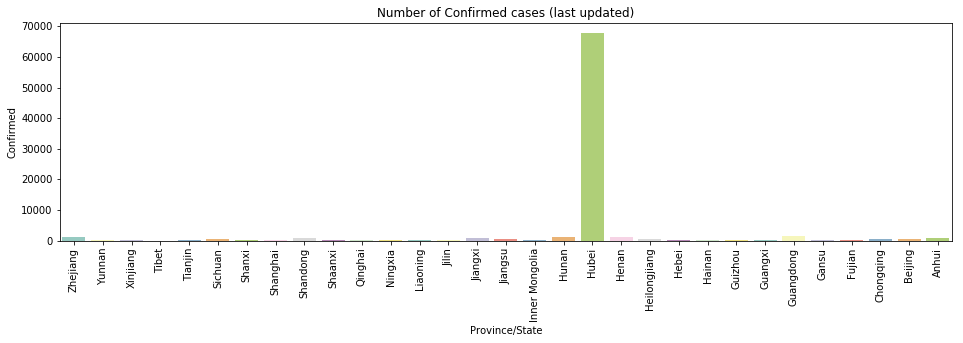

In [22]:
plot_count('Province/State', 'Confirmed', 'Confirmed cases (last updated)', filtered_data_last, size=4)

#### Mainland China - Recovered cases

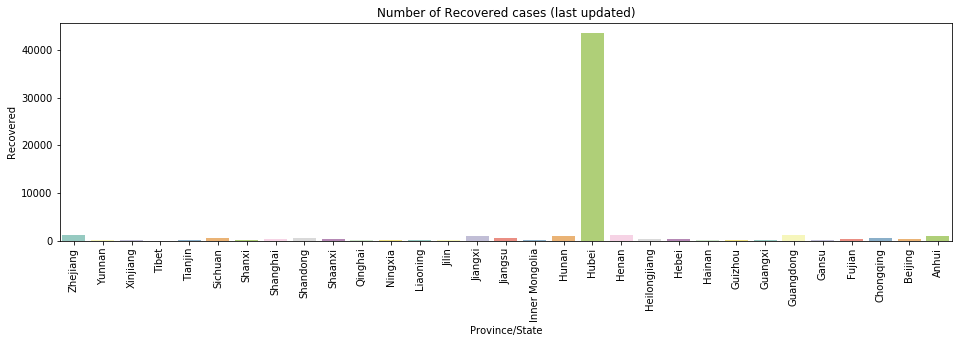

In [23]:
plot_count('Province/State', 'Recovered', 'Recovered cases (last updated)', filtered_data_last, size=4)

#### Mainland China - Deaths

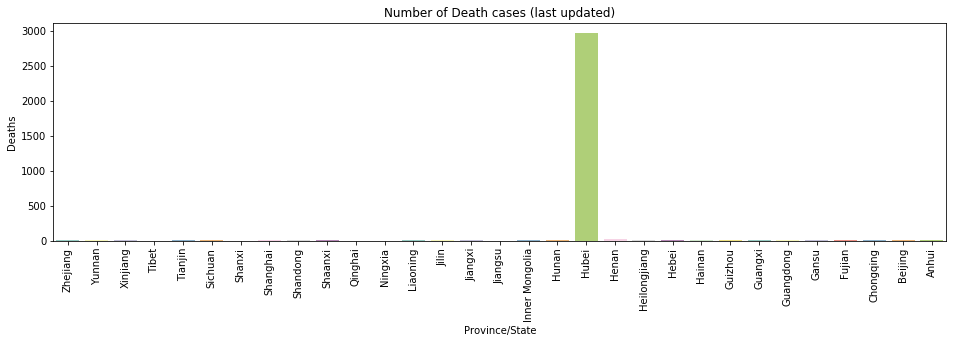

In [24]:
plot_count('Province/State', 'Deaths', 'Death cases (last updated)', filtered_data_last, size=4)

Now we will show again the confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China, as evolved in time.

In [25]:
def plot_time_variation(df, y='Confirmed', hue='Province/State', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x="date", y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    plt.title(f'{y} cases grouped by {hue}')
    plt.show()  

#### Mainland China - Confirmed cases - time evolution

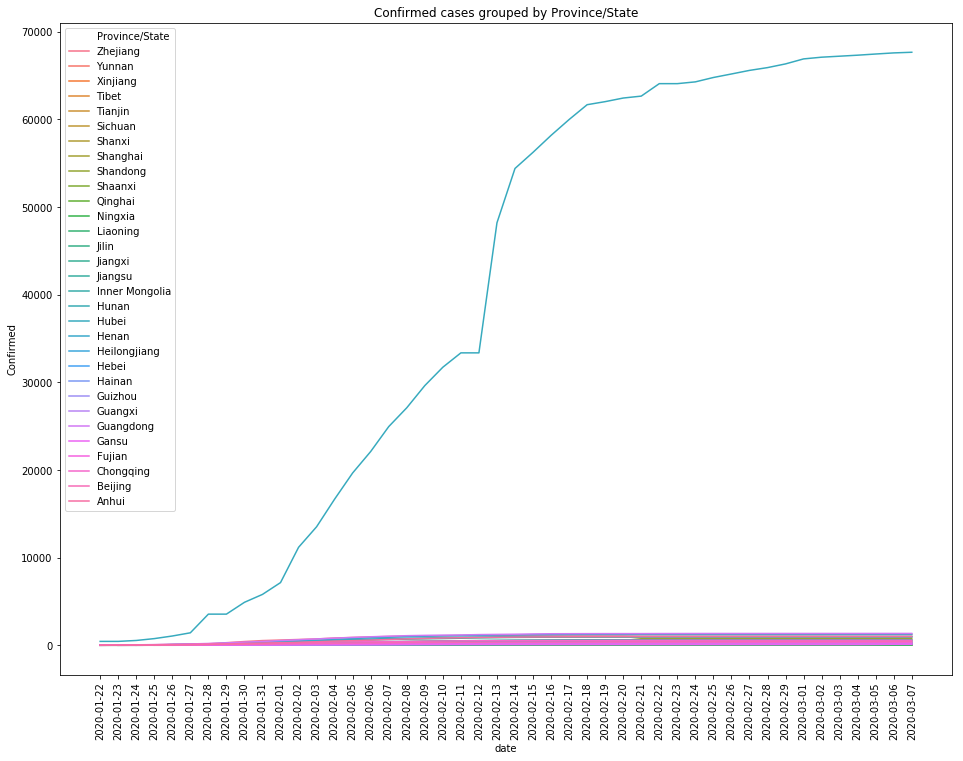

In [26]:
plot_time_variation(data_cn, size=4)

#### Mainland China - Deaths - time evolution

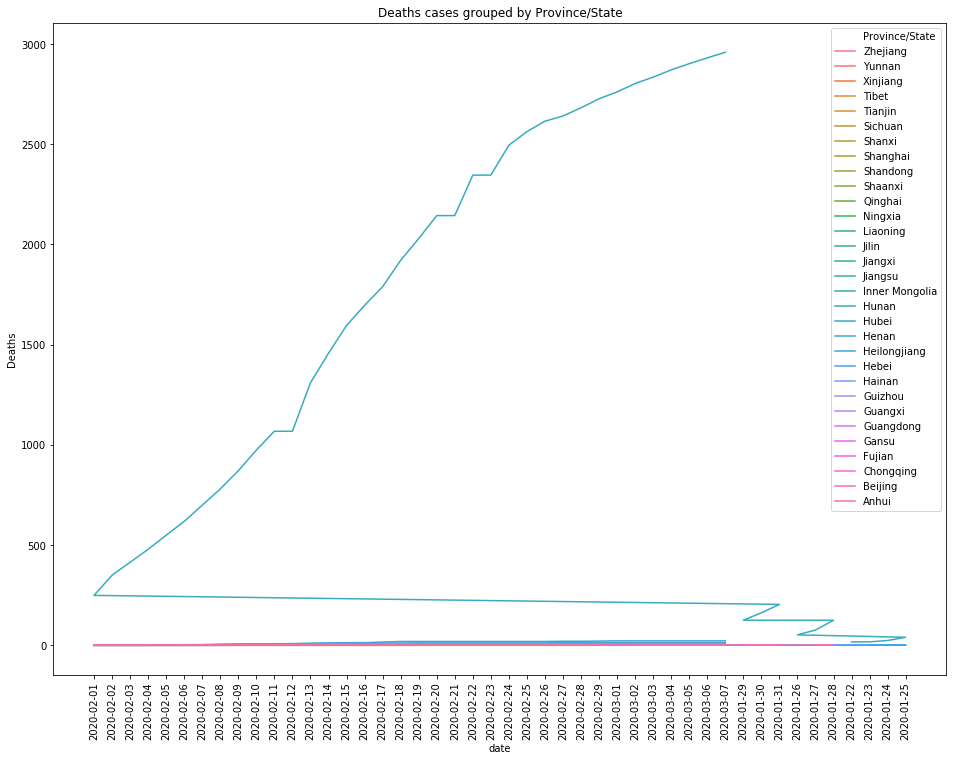

In [27]:
plot_time_variation(data_cn, y='Deaths', size=4)

#### Mainland China - Recovered cases - time evolution

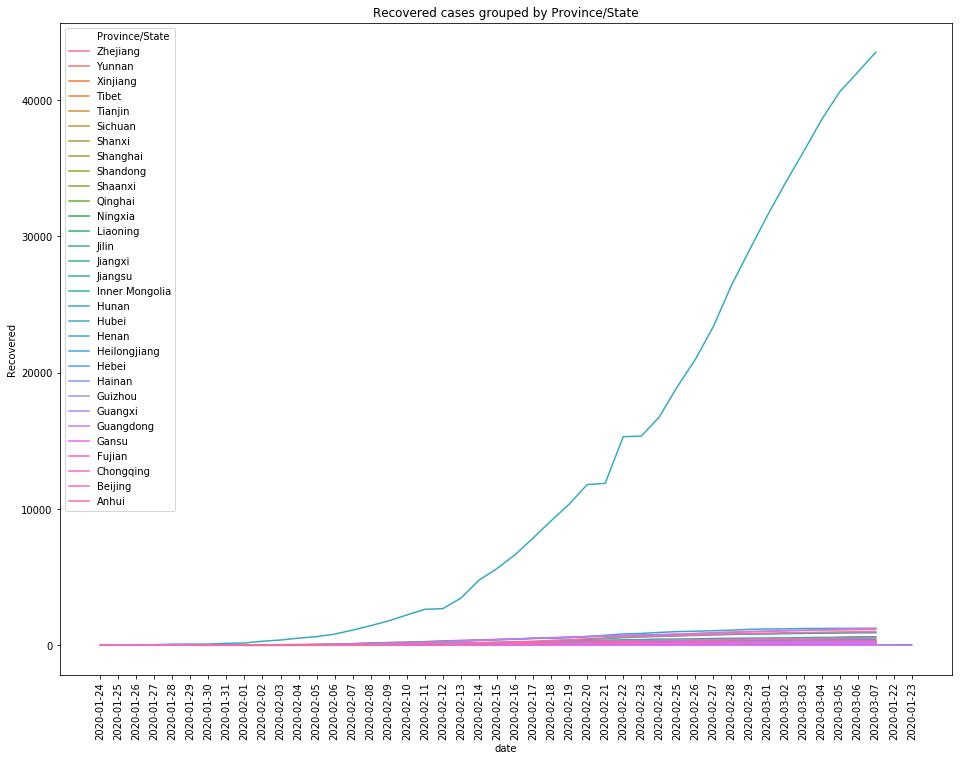

In [28]:
plot_time_variation(data_cn, y='Recovered', size=4)

Let's show only the cases outside Hubei province.

#### Mainland China - Confirmed cases (except Hubei) - time evolution

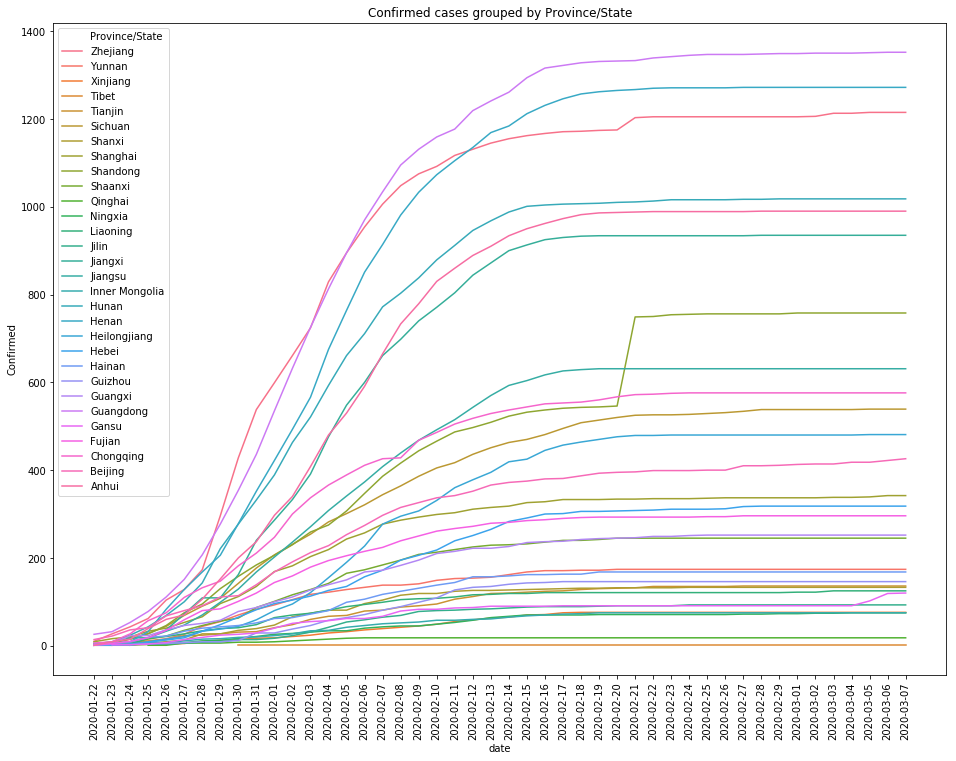

In [29]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')], size=4)

#### Mainland China (except Hubei) - Deaths - time evolution

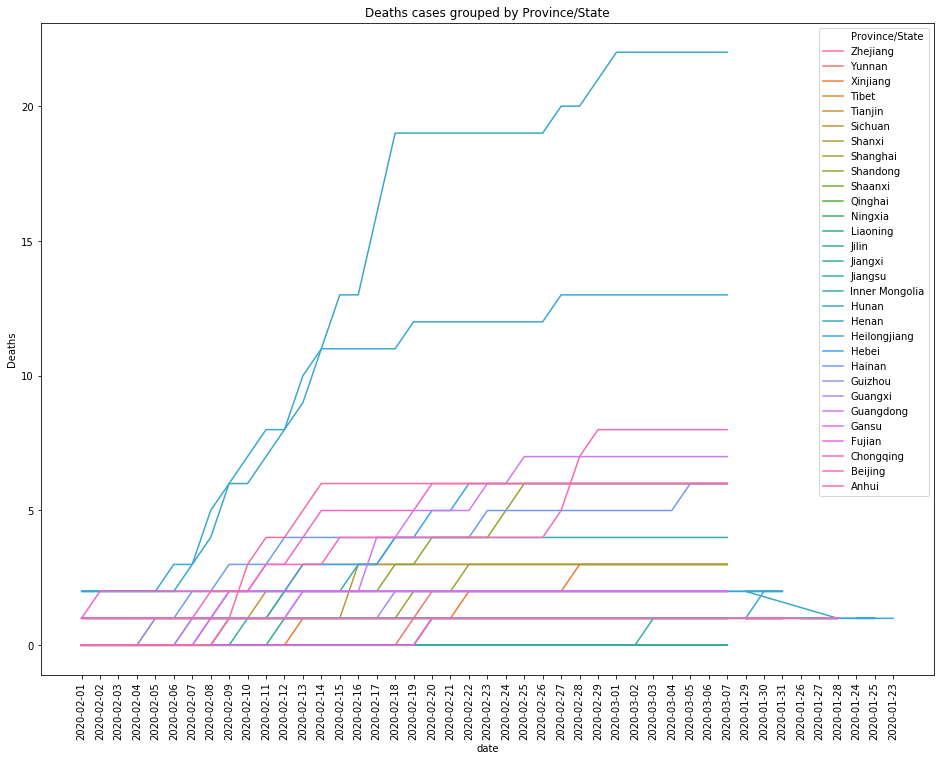

In [30]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')], y='Deaths', size=4)

#### Mainland China (except Hubei) - Recovered cases - time evolution

In [31]:
filtered_data_last.head()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,date,date_str,DateTime
3773,1215.0,Mainland China,1.0,2020-03-07T09:03:05,29.1832,120.0934,Zhejiang,1154.0,2020-03-07,03-07-2020,2020-03-07 09:03:05
3796,174.0,Mainland China,2.0,2020-03-06T03:23:06,24.9740,101.4870,Yunnan,170.0,2020-03-07,03-07-2020,2020-03-06 03:23:06
3812,76.0,Mainland China,3.0,2020-03-07T09:03:05,41.1129,85.2401,Xinjiang,72.0,2020-03-07,03-07-2020,2020-03-07 09:03:05
3937,1.0,Mainland China,0.0,2020-02-12T06:43:02,31.6927,88.0924,Tibet,1.0,2020-03-07,03-07-2020,2020-02-12 06:43:02
3803,136.0,Mainland China,3.0,2020-03-05T03:33:27,39.3054,117.3230,Tianjin,128.0,2020-03-07,03-07-2020,2020-03-05 03:33:27


In [32]:
filtered_data_last = filtered_data_last.reset_index()

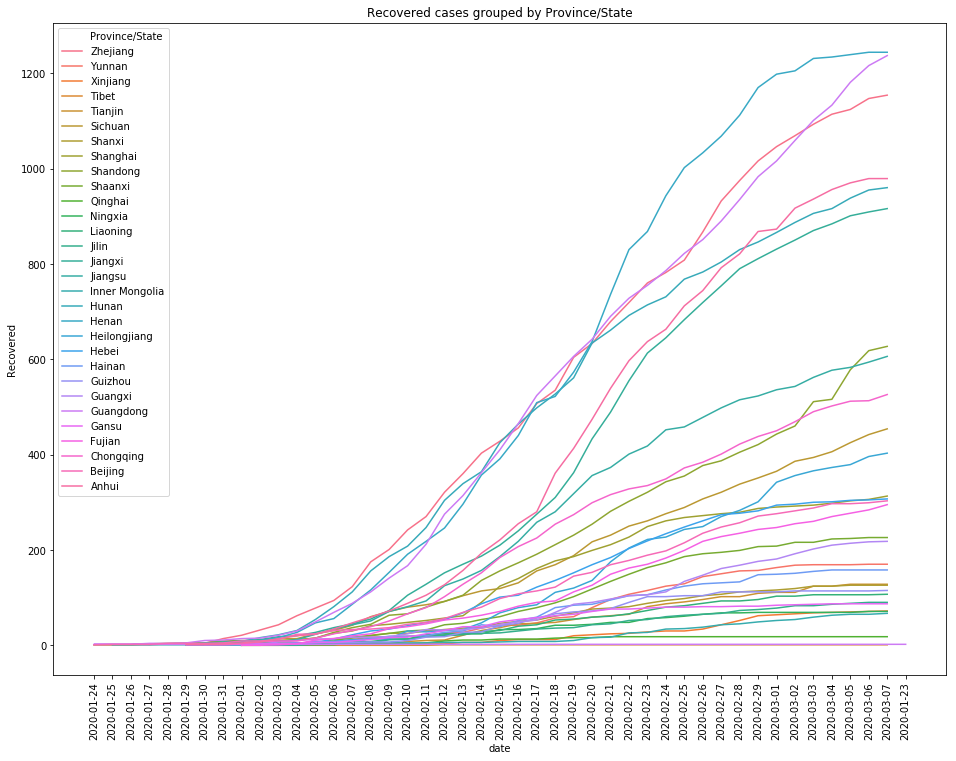

In [33]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')],y='Recovered', size=4)

The following Folium group using **CircleMarker** is created using the inspiration from: https://www.kaggle.com/grebublin/coronavirus-propagation-visualization-forecast Kernel.

In [34]:
m = folium.Map(location=[30, 100], zoom_start=4)

folium.Choropleth(
    geo_data=cn_geo_data,
    name='Confirmed cases - regions',
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.05,
    line_opacity=0.3,
).add_to(m)

radius_min = 2
radius_max = 40
weight = 1
fill_opacity = 0.2

_color_conf = 'red'
group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data_last)):
    lat = filtered_data_last.loc[i, 'Latitude']
    lon = filtered_data_last.loc[i, 'Longitude']
    province = filtered_data_last.loc[i, 'Province/State']
    recovered = filtered_data_last.loc[i, 'Recovered']
    death = filtered_data_last.loc[i, 'Deaths']

    _radius_conf = np.sqrt(filtered_data_last.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max

    _popup_conf = str(province) + '\n(Confirmed='+str(filtered_data_last.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_conf, 
                        popup = _popup_conf, 
                        color = _color_conf, 
                        fill_opacity = fill_opacity,
                        weight = weight, 
                        fill = True, 
                        fillColor = _color_conf).add_to(group0)

group0.add_to(m)
folium.LayerControl().add_to(m)
m

### Rest of the world (not China)

Let's check now the status in the rest of the world.

In [35]:
data_wd = data_df.loc[~(data_df['Country/Region']=="Mainland China")]
data_wd = pd.DataFrame(data_wd.groupby(['Country/Region', 'date'])['Confirmed', 'Recovered', 'Deaths'].sum()).reset_index()
data_wd.columns = ['Country', 'date', 'Confirmed', 'Recovered', 'Deaths' ]
data_wd = data_wd.sort_values(by = ['Country','date'], ascending=False)

#### Rest of the world (not China) - Confirmed cases

In [36]:
#plot_time_variation(data_wd, y='Confirmed', hue='Country', size=4)

#### Rest of the world (not China) - Suspected

#### Rest of the world (not China) - Deaths

In [37]:
#plot_time_variation(data_wd, y='Deaths', hue='Country', size=4)

#### Rest of the world (not China) - Recovered cases

In [38]:
#plot_time_variation(data_wd, y='Recovered', hue='Country', size=4)

### Rest of the World - Confirmed cases - last geographical distribution

We show on a map the distribution of confirmed cases (last information).

In [39]:
filtered_wd_data_last = data_wd.drop_duplicates(subset = ['Country'],keep='first')
filtered_wd_data_last

,Country,date,Confirmed,Recovered,Deaths
1706,Vietnam,2020-03-07,18.0,16.0,0.0
1661,Vatican City,2020-03-07,1.0,0.0,0.0
1659,United Arab Emirates,2020-03-07,45.0,7.0,0.0
1620,Ukraine,2020-03-07,1.0,0.0,0.0
1615,US,2020-03-07,417.0,8.0,17.0
...,...,...,...,...,...
36,Argentina,2020-03-07,8.0,0.0,0.0
31,Andorra,2020-03-07,1.0,0.0,0.0
25,Algeria,2020-03-07,17.0,0.0,0.0
13,Afghanistan,2020-03-07,1.0,0.0,0.0


In [40]:
# check the field for country feature name; uncomment the following lines to check the country feature names
#fullJsonString = None
#with open(wd_geo_data, 'r') as f:
#    fullJsonString = f.read().encode('ascii', errors='ignore')
#fullJsonString

### Rest of the World (not China) - Confirmed Cases

In [41]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_wd_data_last,
    columns=['Country', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed cases (not China)'
).add_to(m)

folium.LayerControl().add_to(m)
m

### All World

We show the geographical distribution of the spread of 2019 Coronavirus.

#### All World - Confirmed cases

In [42]:
data_all_wd = pd.DataFrame(data_df.groupby(['Country/Region', 'Last Update'])['Confirmed',  'Recovered', 'Deaths'].sum()).reset_index()
data_all_wd.columns = ['Country', 'date', 'Confirmed', 'Recovered', 'Deaths' ]
data_all_wd = data_all_wd.sort_values(by = ['Country','date'], ascending=False)
filtered_all_wd_data_last = data_all_wd.drop_duplicates(subset = ['Country'],keep='first')
filtered_all_wd_data_last.loc[filtered_all_wd_data_last['Country']=='Mainland China', 'Country'] = 'China'
filtered_all_wd_data_last

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Country,date,Confirmed,Recovered,Deaths
1673,Vietnam,2020-03-07T10:13:23,18.0,16.0,0.0
1653,Vatican City,2020-03-06T15:43:02,2.0,0.0,0.0
1652,United Arab Emirates,2020-03-07T10:13:22,45.0,7.0,0.0
1636,Ukraine,2020-03-03T15:33:02,5.0,0.0,0.0
1635,US,2020-03-07T23:53:03,23.0,0.0,0.0
...,...,...,...,...,...
11,Argentina,2020-03-07T02:13:09,8.0,0.0,0.0
7,Andorra,2020-03-02T20:23:16,6.0,0.0,0.0
6,Algeria,2020-03-06T01:29:39,34.0,0.0,0.0
1,Afghanistan,2020-02-24T23:33:02,13.0,0.0,0.0


In [43]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_all_wd_data_last,
    columns=['Country', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed cases'
).add_to(m)

folium.LayerControl().add_to(m)
m

#### All World - Deaths

In [44]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='Deaths',
    data=filtered_all_wd_data_last,
    columns=['Country', 'Deaths'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Deaths'
).add_to(m)

folium.LayerControl().add_to(m)
m

#### All World - Recovered cases

In [45]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_all_wd_data_last,
    columns=['Country', 'Recovered'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Recovered'
).add_to(m)

folium.LayerControl().add_to(m)
m